## Preprocessing

In [9]:
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
import stanza
import re
from nltk.corpus import stopwords
import contractions
from stanza.utils.conll import CoNLL

# Initialize Stanza NLP model
stanza.download('en')
nlp = stanza.Pipeline('en', processors='tokenize,lemma,pos')

# Load Datasets 
train_df = pd.read_json('data/labeled_data/labeled-train.model-agnostic.json')
test_df = pd.read_json('data/labeled_data/labeled-test.model-agnostic.json')

2024-12-12 13:45:08 INFO: Downloaded file to C:\Users\Admin\stanza_resources\resources.json
2024-12-12 13:45:09 INFO: Downloading default packages for language: en (English) ...
2024-12-12 13:45:10 INFO: File exists: C:\Users\Admin\stanza_resources\en\default.zip
2024-12-12 13:45:12 INFO: Finished downloading models and saved to C:\Users\Admin\stanza_resources
2024-12-12 13:45:12 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-12-12 13:45:13 INFO: Downloaded file to C:\Users\Admin\stanza_resources\resources.json
2024-12-12 13:45:13 WARNING: Language en package default expects mwt, which has been added
2024-12-12 13:45:13 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2024-12-12 13:45:13 INFO: Using device: cpu
2024-12-12 13:45:13 INFO: Loading: tokenize
C:\Users\Admin\anaconda3\envs\testenv\lib\site-packages\stanza\models\tokenization\trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a 

In [10]:
# Filter for Specific Task
def load_and_filter_data(df, task_type, column_to_keep1, column_to_keep2, column_to_keep3):
    # Filter for the specified task type
    df = df[df['task'].isin([task_type])].reset_index(drop=True)
    
    # Define columns to drop, keeping only "hyp" and the specified column ("src" or "tgt")
    columns_to_drop = [col for col in df.columns if col not in ['hyp','label', column_to_keep1, column_to_keep2, column_to_keep3]]
    df = df.drop(columns=columns_to_drop)
    
    return df

# Load train, test, and validation datasets with specified task type and column to keep
pg_train_df = load_and_filter_data(train_df, 'PG', 'src', 'label', 'p(Hallucination)')
pg_test_df = load_and_filter_data(test_df, 'PG', 'src', 'label', 'p(Hallucination)')

In [11]:
# Text Segmentation, Normalization, and Stopword Removal Function
def normalize_text(text, remove_stopwords=False):
    expanded_text = contractions.fix(text).lower()  # Expand contractions and lowercase
    text_no_punctuation = re.sub(r'[^\w\s]', '', expanded_text) # Remove punctuation
    
    # Optionally remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        # Tokenize to remove stopwords and then join back to a single string
        text_no_stopwords = ' '.join(word for word in text_no_punctuation.split() if word not in stop_words)
        return text_no_stopwords
    
    return text_no_punctuation

# Lemmatization Function
def lemmatize_text(text):
    doc = nlp(text)
    return [word.lemma for sentence in doc.sentences for word in sentence.words]

# Apply Preprocessing Steps to Dataset
def preprocess_dataset(df, column):
    # Normalize text
    df['hyp_normalized'] = df['hyp'].apply(normalize_text)
    df[f'{column}_normalized'] = df[column].apply(normalize_text)
    
    # Sentence Segmentation
    df['hyp_sentences'] = df['hyp_normalized'].apply(sent_tokenize)
    df[f'{column}_sentences'] = df[f'{column}_normalized'].apply(sent_tokenize)
    
    # Tokenization
    df['hyp_tokens'] = df['hyp_sentences'].apply(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
    df[f'{column}_tokens'] = df[f'{column}_sentences'].apply(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
    
    # Lemmatization
    df['hyp_lemmas'] = df['hyp_normalized'].apply(lemmatize_text)
    df[f'{column}_lemmas'] = df[f'{column}_normalized'].apply(lemmatize_text)
    
    return df

# pg_train_df = preprocess_dataset(pg_train_df, 'src')
# pg_test_df = preprocess_dataset(pg_test_df, 'src')

# Save preprocessed dataset to a CSV file
# preprocessed_file_path = "data/labeled_data/preprocessed/pg_test_preprocessed_dataset.csv"
# pg_test_df.to_csv(preprocessed_file_path, index=False)

In [12]:
pg_train_df = pd.read_csv('data/labeled_data/preprocessed/pg_preprocessed_dataset.csv')
pg_test_df = pd.read_csv('data/labeled_data/preprocessed/pg_test_preprocessed_dataset.csv')

# Map labels to 0 and 1
pg_train_df['label'] = pg_train_df['label'].map({'Not Hallucination': 0, 'Hallucination': 1})
pg_test_df['label'] = pg_test_df['label'].map({'Not Hallucination': 0, 'Hallucination': 1})

## Naive Bayes
**1. Importing Required Libraries**

**2. Loading the Data**
- Load the labeled dataset from the CSV file (`pg_train_label.csv`).
- Remove any rows with missing values to ensure clean data.

**3. Combining Text Features**
- Combine the two columns (`hyp_lemmas` and `src_lemmas`) that are most likely the core inputs in our dataset for detecting hallucinations. By combining these columns, you're essentially merging the two key pieces of information that your model needs.
- This merged text will be used as input for the model, as both columns may contain complementary information about the task.

**4. Splitting the Data**
- **`X`**: Features (in this case, the combined text data).
- **`y`**: Labels (`label` column).

**5. Converting Text to Numerical Features (TF-IDF Vectorization)**
- **TF-IDF Vectorization**:
  - Converts the text into numerical features by analyzing the importance of each word (or n-grams) in the document.
  - **`ngram_range=(1, 2)`**: Includes single words (unigrams) and pairs of consecutive words (bigrams).
  - **`max_features=5000`**: Limits the vocabulary to the top 5,000 most important words or phrases based on their TF-IDF score.
- Apply the vectorizer to the training data (`fit_transform`) and the testing data (`transform`).

**6. Training a Naive Bayes Classifier**
- A **Multinomial Naive Bayes classifier** is initialized and trained using the vectorized training data (`X_train_vec`) and corresponding labels (`y_train`).
- This algorithm is suitable for text classification problems as it assumes word frequencies follow a multinomial distribution.

**7. Making Predictions**
- Use the trained model to predict the labels for the test set (`X_test_vec`).

**8. Evaluating the Model**
- **`accuracy_score`**: Computes the percentage of correctly predicted labels in the test set.
- **`classification_report`**: Provides a detailed evaluation of the model’s performance, including:
  - **Precision**: How many of the predicted positives are true positives.
  - **Recall**: How many of the actual positives were correctly identified.
  - **F1-score**: Harmonic mean of precision and recall.
  - **Support**: Number of actual occurrences for each label.

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import ast
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords

# Use preprocessed training and testing datasets
train_data = pg_train_df.dropna()
test_data = pg_test_df.dropna()

# Convert string representations of lists to actual lists
train_data['hyp_lemmas'] = train_data['hyp_lemmas'].apply(ast.literal_eval)
train_data['src_lemmas'] = train_data['src_lemmas'].apply(ast.literal_eval)
test_data['hyp_lemmas'] = test_data['hyp_lemmas'].apply(ast.literal_eval)
test_data['src_lemmas'] = test_data['src_lemmas'].apply(ast.literal_eval)

# Combine `hyp_lemmas` and `src_lemmas` into a single text feature
train_data['combined_text'] = train_data['hyp_lemmas'].apply(lambda x: " ".join(x)) + " " + train_data['src_lemmas'].apply(lambda x: " ".join(x))
test_data['combined_text'] = test_data['hyp_lemmas'].apply(lambda x: " ".join(x)) + " " + test_data['src_lemmas'].apply(lambda x: " ".join(x))

# Extract features and labels
X_train = train_data['combined_text']
y_train = train_data['label']

X_test = test_data['combined_text']
y_test = test_data['label']

In [8]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, stop_words=None)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a Naive Bayes classifier
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vec, y_train)

# Predict on test set
y_pred = naive_bayes.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.536
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.66      0.55       163
           1       0.63      0.44      0.52       212

    accuracy                           0.54       375
   macro avg       0.55      0.55      0.54       375
weighted avg       0.56      0.54      0.53       375



### Hyperparameter

In [9]:
# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorizer
    ('nb', MultinomialNB())       # Naive Bayes classifier
])

# Define the parameter grid
param_grid = {
    'tfidf__max_features': [2000, 3000, 5000, 10000],  # Increase feature size
    'tfidf__ngram_range': [(1, 1), (1, 2)],            # Focus on unigrams and bigrams
    'tfidf__min_df': [1, 2, 3],                        # Tune minimum document frequency
    'tfidf__stop_words': [None, stopwords.words('english')],  # Include stopword removal
    'nb__alpha': [1.0, 0.5, 0.1, 0.01]                # Fine-tune smoothing
}

# Perform grid search with stratified cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=stratified_cv, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
print(f"Best Parameters: {best_params}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Parameters: {'nb__alpha': 1.0, 'tfidf__max_features': 3000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.75      0.59       163
           1       0.66      0.38      0.48       212

    accuracy                           0.54       375
   macro avg       0.57      0.56      0.53       375
weighted avg       0.58      0.54      0.53       375



### Vectara

**1. Data Loading and Preparation**
- Load and prepare the validation (`pg_val`) and test (`pg_test`) datasets for use.

**2. Model Evaluation**
- `assess_performance(true_labels, pred_labels)`: Calculates and prints classification metrics:
      - **Accuracy:** Proportion of correct predictions.
      - **Precision:** Fraction of correctly predicted positive cases among all predicted positive cases.
      - **Recall:** Fraction of correctly predicted positive cases among all actual positive cases.
      - **F1-Score:** Harmonic mean of precision and recall.
  
- `finding_threshold(similarities, true_labels)`: Iteratively evaluates different thresholds for classification. Selects the threshold that maximizes accuracy.

- `get_prediction(probs, threshold)`: Converts probabilities into binary predictions (`0` or `1`) based on a given threshold.

- `evaluate_model(model, pairs, true_labels, threshold=None)`: Generates predictions for the input pairs. If a threshold is provided, it computes binary predictions and evaluates metrics.

**3. Model Loading**
- Loads a pre-trained hallucination evaluation model from Hugging Face's Transformers library.
- The `trust_remote_code=True` allows dynamic loading of custom model configurations from the repository.

**4. Validation Phase**
- Prepares the `pg_val` dataset into pairs of hypothesis and source using `prepare_pairs()`.
- Uses `evaluate_model()` to generate predictions for the validation pairs.
- Calls `finding_threshold()` to identify the threshold that maximizes accuracy on the validation dataset.

**5. Testing Phase**
- Prepares the `pg_test` dataset into pairs of hypothesis and source using `prepare_pairs()`.
- Uses `evaluate_model()` to: Generate predictions for the test pairs. Apply the threshold obtained from the validation phase. Evaluate and print performance metrics on the test dataset.

#### **Assumptions and Limitations**
1. **Assumptions:**
   - The model can process raw text pairs directly.
   - The `model.predict()` function returns probabilities or scores compatible with the `finding_threshold` and `get_prediction` functions.

2. **Limitations:**
   - No explicit tokenization is performed; this assumes the model internally handles tokenization.
   - Threshold optimization only considers accuracy and does not optimize for other metrics like F1-score.
   - The code may fail if the model outputs logits or uses a custom input format.


In [21]:
###################### Preparing Data #########################

# Load validation and test datasets
pg_val = pg_train_df
pg_test = pg_test_df

# Extract true labels
true_labels_val = pg_test_df['label']
true_labels_test = pg_test_df['label']

You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.


Accuracy: 0.64
Precision: 0
Recall: 0.0
F1-Score: 0
Accuracy: 0.656
Precision: 0.75
Recall: 0.06666666666666667
F1-Score: 0.12244897959183675
Accuracy: 0.664
Precision: 0.8
Recall: 0.08888888888888889
F1-Score: 0.15999999999999998
Accuracy: 0.656
Precision: 0.625
Recall: 0.1111111111111111
F1-Score: 0.18867924528301885
Accuracy: 0.664
Precision: 0.6666666666666666
Recall: 0.13333333333333333
F1-Score: 0.2222222222222222
Accuracy: 0.664
Precision: 0.6666666666666666
Recall: 0.13333333333333333
F1-Score: 0.2222222222222222
Accuracy: 0.656
Precision: 0.5833333333333334
Recall: 0.15555555555555556
F1-Score: 0.2456140350877193
Accuracy: 0.648
Precision: 0.5384615384615384
Recall: 0.15555555555555556
F1-Score: 0.24137931034482757
Accuracy: 0.632
Precision: 0.4666666666666667
Recall: 0.15555555555555556
F1-Score: 0.23333333333333334
Accuracy: 0.632
Precision: 0.4666666666666667
Recall: 0.15555555555555556
F1-Score: 0.23333333333333334
Accuracy: 0.632
Precision: 0.47058823529411764
Recall: 0.1

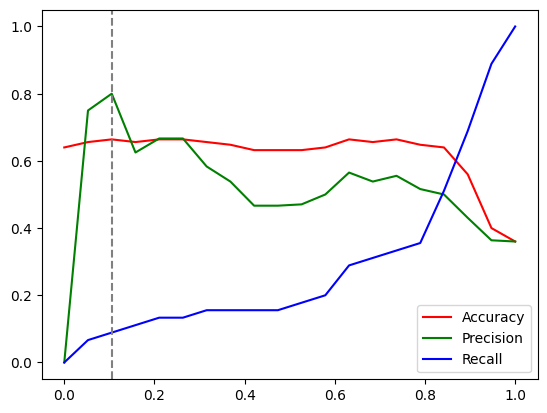

Accuracy: 0.7706666666666667
Precision: 0.7037037037037037
Recall: 0.1958762886597938
F1-Score: 0.3064516129032258


In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification

###################### Preparing Data #########################

def load_data(file_path, task_type):
    """Load and filter data for a specific task."""
    with open(file_path) as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df[df["task"] == task_type]

def extract_true_labels(df):
    """Extract true labels (0 for Not Hallucination, 1 for Hallucination)."""
    true_labels = df["label"].map({"Not Hallucination": 0, "Hallucination": 1}).tolist()
    df["true_labels"] = true_labels
    return true_labels

# Load validation and test datasets
pg_val = load_data("data/val.model-agnostic.json", "PG")
pg_test = load_data("data/test.model-agnostic.json", "PG")

# Extract true labels
true_labels_val = extract_true_labels(pg_val)
true_labels_test = extract_true_labels(pg_test)

################### Functions to Choose and Evaluate Model ############################

def assess_performance(true_labels, pred_labels):
    """Assess performance of the classifier."""
    tp = sum((true == 1 and pred == 1) for true, pred in zip(true_labels, pred_labels))
    tn = sum((true == 0 and pred == 0) for true, pred in zip(true_labels, pred_labels))
    fp = sum((true == 0 and pred == 1) for true, pred in zip(true_labels, pred_labels))
    fn = sum((true == 1 and pred == 0) for true, pred in zip(true_labels, pred_labels))

    accuracy = (tp + tn) / len(true_labels)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)

    return accuracy, precision, recall, f1

def finding_threshold(similarities, true_labels):
    """Find the best threshold for classification based on validation data."""
    thresholds = np.linspace(0, 1, 20)
    accs, recs, precs = [], [], []

    for thresh in thresholds:
        pred_labels = [0 if sim > thresh else 1 for sim in similarities]
        acc, prec, rec, _ = assess_performance(true_labels, pred_labels)
        accs.append(acc)
        recs.append(rec)
        precs.append(prec)

    best_thresh = thresholds[np.argmax(accs)]
    print("Highest accuracy at a threshold of:", best_thresh)

    # Plot performance metrics
    plt.plot(thresholds, accs, label="Accuracy", color="red")
    plt.plot(thresholds, precs, label="Precision", color="green")
    plt.plot(thresholds, recs, label="Recall", color="blue")
    plt.axvline(best_thresh, color="grey", linestyle="--")
    plt.legend()
    plt.show()

    return best_thresh

def get_prediction(probs, threshold):
    """Convert probabilities to binary predictions based on a threshold."""
    return [0 if prob > threshold else 1 for prob in probs]

######################### Defining and Testing Model ##############################

def prepare_pairs(df):
    """Prepare input pairs for the model."""
    return [(hyp, tgt) for hyp, tgt in zip(df["hyp"], df["src"])]

def evaluate_model(model, pairs, true_labels, threshold=None):
    """Evaluate the model on the given data."""
    predictions = model.predict(pairs)
    if threshold is not None:
        pred_labels = get_prediction(predictions, threshold)
        assess_performance(true_labels, pred_labels)
    else:
        return predictions

# Load Vectara model
model = AutoModelForSequenceClassification.from_pretrained(
    "vectara/hallucination_evaluation_model", trust_remote_code=True
)

# Validation phase
pairs_val = prepare_pairs(pg_val)
pred_vectara_val = evaluate_model(model, pairs_val, true_labels_val)
thresh_vectara = finding_threshold(pred_vectara_val, true_labels_val)

# Testing phase
pairs_test = prepare_pairs(pg_test)
evaluate_model(model, pairs_test, true_labels_test, thresh_vectara)

In [19]:
pg_test

,src,hyp,label,p(Hallucination),hyp_normalized,src_normalized,hyp_sentences,src_sentences,hyp_tokens,src_tokens,hyp_lemmas,src_lemmas
0,Here she comes.,"Here she comes, here she comes.",0,0.50,here she comes here she comes,here she comes,['here she comes here she comes'],['here she comes'],"[['here', 'she', 'comes', 'here', 'she', 'come...","[['here', 'she', 'comes']]","['here', 'she', 'come', 'here', 'she', 'come']","['here', 'she', 'come']"
1,Everything will be allright.,Everythings fine.,1,1.00,everythings fine,everything will be allright,['everythings fine'],['everything will be allright'],"[['everythings', 'fine']]","[['everything', 'will', 'be', 'allright']]","['everythings', 'fine']","['everything', 'will', 'be', 'allright']"
2,I'm not familiar with who that is.,I am unfamiliar with who that is.,0,0.00,i am unfamiliar with who that is,i am not familiar with who that is,['i am unfamiliar with who that is'],['i am not familiar with who that is'],"[['i', 'am', 'unfamiliar', 'with', 'who', 'tha...","[['i', 'am', 'not', 'familiar', 'with', 'who',...","['I', 'be', 'unfamiliar', 'with', 'who', 'that...","['I', 'be', 'not', 'familiar', 'with', 'who', ..."
3,It's turning me into a crazy person.,It turns me into madness.,1,1.00,it turns me into madness,it is turning me into a crazy person,['it turns me into madness'],['it is turning me into a crazy person'],"[['it', 'turns', 'me', 'into', 'madness']]","[['it', 'is', 'turning', 'me', 'into', 'a', 'c...","['it', 'turn', 'I', 'into', 'madness']","['it', 'be', 'turn', 'I', 'into', 'a', 'crazy'..."
4,I'm joking.,I'm--I'm joking.,0,0.25,i ami am joking,i am joking,['i ami am joking'],['i am joking'],"[['i', 'ami', 'am', 'joking']]","[['i', 'am', 'joking']]","['I', 'ami', 'be', 'joke']","['I', 'be', 'joke']"
...,...,...,...,...,...,...,...,...,...,...,...,...
175,I'll put some clothes on.,I'll get some clothing.,1,0.75,i will get some clothing,i will put some clothes on,['i will get some clothing'],['i will put some clothes on'],"[['i', 'will', 'get', 'some', 'clothing']]","[['i', 'will', 'put', 'some', 'clothes', 'on']]","['I', 'will', 'get', 'some', 'clothing']","['I', 'will', 'put', 'some', 'clothes', 'on']"
176,"God, what ain't I tried.","Gee, I've tried so hard.",1,1.00,gee i have tried so hard,god what are not i tried,['gee i have tried so hard'],['god what are not i tried'],"[['gee', 'i', 'have', 'tried', 'so', 'hard']]","[['god', 'what', 'are', 'not', 'i', 'tried']]","['gee', 'I', 'have', 'try', 'so', 'hard']","['god', 'what', 'be', 'not', 'I', 'try']"
177,"Hey, look what you did.","Hey, hey, hey, look what you've done.",0,0.50,hey hey hey look what you have done,hey look what you did,['hey hey hey look what you have done'],['hey look what you did'],"[['hey', 'hey', 'hey', 'look', 'what', 'you', ...","[['hey', 'look', 'what', 'you', 'did']]","['hey', 'hey', 'hey', 'look', 'what', 'you', '...","['hey', 'look', 'what', 'you', 'do']"
178,I'm holding a firearm.,I hold a weapon.,1,1.00,i hold a weapon,i am holding a firearm,['i hold a weapon'],['i am holding a firearm'],"[['i', 'hold', 'a', 'weapon']]","[['i', 'am', 'holding', 'a', 'firearm']]","['I', 'hold', 'a', 'weapon']","['I', 'be', 'hold', 'a', 'firearm']"


### **Original Code**

- **Problem**: The original code assumes that the Vectara model can process raw text pairs (`(hyp, src)`) directly without any preprocessing. It relies on a `.predict()` method, which the Vectara model does not implement.

1. **Key Assumptions in Original Code**:
   - **`prepare_pairs`**: Extracts pairs `(hyp, src)` directly from the dataset without any transformation.
   - The model can process these pairs and return predictions using `model.predict(pairs)`.
   - **No explicit preprocessing** is performed to convert raw text into numerical representations (`input_ids` and `attention_mask`).

2. **Why This Fails**:
   - The Vectara model, like many Transformer-based models, requires numerical inputs in the form of `input_ids` and `attention_mask`.
   - Without preprocessing, the model does not know how to interpret raw text and will fail.

---

### **Updated Code**

- **Solution**: The updated code introduces a preprocessing step (`preprocess_text`) to convert raw text pairs into numerical tensors (`input_ids`, `attention_mask`) suitable for the Vectara model.

1. **Preprocessing**:
   - **`preprocess_text`**: Takes a text pair `(hyp, src)` and:
     - Concatenates the `hyp_normalized` and `src_normalized` with a `[SEP]` separator.
     - Converts the combined text into ASCII codes (or tokens) and pads/truncates to a fixed length (512 tokens).
     - Outputs `input_ids` and `attention_mask` tensors.

2. **Evaluation Changes**:
   - **`evaluate_model`**:
     - Processes each text pair using `preprocess_text` before passing it to the model.
     - Uses `model(**inputs)` to pass the preprocessed inputs to the Vectara model.
     - Applies `softmax` to the model's `logits` to compute probabilities for the positive class (hallucination).
   - Introduces a workflow that works with the model's native input requirements.

3. **Threshold Selection**:
   - **`finding_threshold`**:
     - Finds the best decision threshold on validation data to optimize F1-score.
     - This makes the classification more robust, as probabilities are converted into binary labels based on the threshold.

4. **Improved Compatibility**:
   - The updated code adheres to the Vectara model's expected input format (`input_ids` and `attention_mask`).
   - It ensures that the model receives properly preprocessed inputs, enabling it to generate meaningful predictions.

---

### **Key Differences Between Original and Updated Code**

| Aspect                 | Original Code                                | Updated Code                                                                                     |
|------------------------|----------------------------------------------|--------------------------------------------------------------------------------------------------|
| Input Assumption       | Passes raw text pairs to the model directly. | Preprocesses text pairs into numerical tensors (`input_ids`, `attention_mask`) before passing to the model. |
| Preprocessing          | None.                                       | `preprocess_text` converts text to model-compatible format.                                     |
| Model Invocation       | Assumes `.predict()` method exists.          | Uses `model(**inputs)` for compatibility with Hugging Face's API.                              |
| Threshold Selection    | Binary threshold fixed in `get_prediction`. | Dynamically selects the best threshold using validation data.                                  |
| Compatibility          | Fails for Vectara's expected input format.   | Fully compatible with Vectara's requirements.                                                  |

---

### **Why the Update is Necessary**
- The Vectara model **does not implement raw text handling** directly, so preprocessing is required.
- By introducing preprocessing (`preprocess_text`), the updated code ensures:
  - Inputs are converted to the required numerical tensors (`input_ids`, `attention_mask`).
  - The model functions as intended, returning valid outputs.
- Additionally, dynamic thresholding improves performance by optimizing the F1-score for the task of hallucination detection.

In [25]:
import torch
import json
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch.nn.functional as F

###################### Data Loading and Preparation #########################

def load_data(file_path, task_type):
    """Load and filter data for a specific task."""
    with open(file_path) as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df[df["task"] == task_type]

def extract_true_labels(df):
    """Extract true labels (0 for Not Hallucination, 1 for Hallucination)."""
    true_labels = df["label"].map({"Not Hallucination": 0, "Hallucination": 1}).tolist()
    df["true_labels"] = true_labels
    return true_labels

###################### Custom Preprocessing #########################

def preprocess_text(pair):
    """Manually preprocess text pairs into input_ids and attention_mask."""
    hyp, src = pair
    # Simplified preprocessing; adjust based on model needs
    input_ids = [ord(c) for c in f"{hyp} [SEP] {src}"[:512]]  # Limit to 512 tokens
    attention_mask = [1] * len(input_ids)
    
    # Pad to fixed length
    max_len = 512
    input_ids += [0] * (max_len - len(input_ids))
    attention_mask += [0] * (max_len - len(attention_mask))
    
    return {
        "input_ids": torch.tensor([input_ids]),
        "attention_mask": torch.tensor([attention_mask])
    }

###################### Model Evaluation #########################

def evaluate_model(model, pairs, true_labels, threshold=None):
    """Evaluate the model using custom preprocessing."""
    probabilities = []
    
    for pair in pairs:
        inputs = preprocess_text(pair)
        output = model(**inputs)
        prob = F.softmax(output.logits, dim=1).detach().numpy()[0][1]  # Probability of positive class
        probabilities.append(prob)
    
    if threshold is not None:
        pred_labels = [1 if prob >= threshold else 0 for prob in probabilities]
        assess_performance(true_labels, pred_labels)
    else:
        return np.array(probabilities)

def assess_performance(true_labels, pred_labels):
    """Assess performance of the classifier."""
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="binary")
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

def finding_threshold(probabilities, true_labels):
    """Find the best threshold for classification based on validation data."""
    thresholds = np.linspace(0, 1, 20)
    best_thresh = 0
    best_f1 = 0
    
    for thresh in thresholds:
        pred_labels = [1 if prob >= thresh else 0 for prob in probabilities]
        _, _, _, f1 = assess_performance(true_labels, pred_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    
    print(f"Best threshold: {best_thresh}")
    return best_thresh

###################### Workflow #########################

# Load model
model_name = "vectara/hallucination_evaluation_model"
model = AutoModelForSequenceClassification.from_pretrained(model_name, trust_remote_code=True)

# Load datasets
pg_val = load_data("data/val.model-agnostic.json", "PG")
pg_test = load_data("data/test.model-agnostic.json", "PG")

# Extract true labels
true_labels_val = extract_true_labels(pg_val)
true_labels_test = extract_true_labels(pg_test)

# Prepare input pairs
pairs_val = [(row["hyp"], row["src"]) for _, row in pg_val.iterrows()]
pairs_test = [(row["hyp"], row["src"]) for _, row in pg_test.iterrows()]

# Validation phase
probabilities_val = evaluate_model(model, pairs_val, true_labels_val)
thresh_vectara = finding_threshold(probabilities_val, true_labels_val)

# Testing phase
evaluate_model(model, pairs_test, true_labels_test, threshold=thresh_vectara)


You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.


Accuracy: 0.3600
Precision: 0.3600
Recall: 1.0000
F1-Score: 0.5294
Accuracy: 0.3680
Precision: 0.3629
Recall: 1.0000
F1-Score: 0.5325
Accuracy: 0.3680
Precision: 0.3607
Recall: 0.9778
F1-Score: 0.5269
Accuracy: 0.3680
Precision: 0.3559
Recall: 0.9333
F1-Score: 0.5153
Accuracy: 0.3600
Precision: 0.3504
Recall: 0.9111
F1-Score: 0.5062
Accuracy: 0.3600
Precision: 0.3504
Recall: 0.9111
F1-Score: 0.5062
Accuracy: 0.3680
Precision: 0.3534
Recall: 0.9111
F1-Score: 0.5093
Accuracy: 0.3680
Precision: 0.3534
Recall: 0.9111
F1-Score: 0.5093
Accuracy: 0.3760
Precision: 0.3565
Recall: 0.9111
F1-Score: 0.5125
Accuracy: 0.4000
Precision: 0.3661
Recall: 0.9111
F1-Score: 0.5223
Accuracy: 0.4080
Precision: 0.3694
Recall: 0.9111
F1-Score: 0.5256
Accuracy: 0.4080
Precision: 0.3694
Recall: 0.9111
F1-Score: 0.5256
Accuracy: 0.4160
Precision: 0.3727
Recall: 0.9111
F1-Score: 0.5290
Accuracy: 0.4160
Precision: 0.3704
Recall: 0.8889
F1-Score: 0.5229
Accuracy: 0.4320
Precision: 0.3774
Recall: 0.8889
F1-Score: 0.

C:\Users\Admin\anaconda3\envs\testenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2667
Precision: 0.2608
Recall: 1.0000
F1-Score: 0.4136


Class Distribution:
Not Hallucination: 80 samples (64.00%)
Hallucination: 45 samples (36.00%)


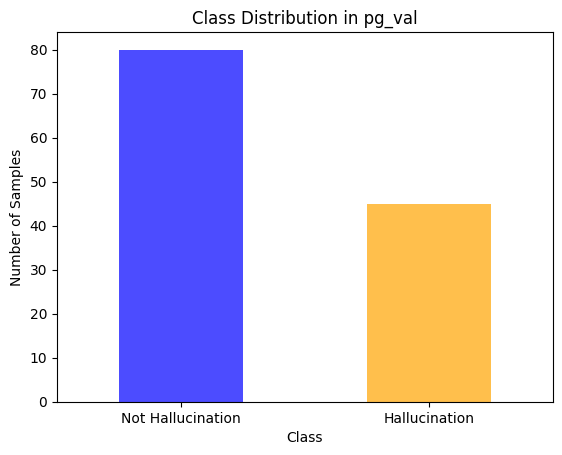

In [24]:
# Check class distribution in pg_val
def check_class_distribution(df):
    """Check the class distribution in the dataset."""
    class_counts = df['label'].value_counts()
    total_samples = len(df)
    
    print("Class Distribution:")
    for label, count in class_counts.items():
        print(f"{label}: {count} samples ({(count / total_samples) * 100:.2f}%)")
    
    return class_counts

# Call the function to check class distribution
class_distribution = check_class_distribution(pg_val)

# Visualize the class distribution
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar', color=['blue', 'orange'], alpha=0.7)
plt.title("Class Distribution in pg_val")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.show()
